# Урок 6. Градиентный бустинг

In [1]:
### Задача 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в
### ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

In [3]:
#Разделим выборку на обучающую и тестовую в соотношении 75/25.
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [26]:
#Напишем функцию, реализующую предсказание в градиентном бустинге.
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
#В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
#Реализуем функцию обучения градиентного бустинга.
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    return mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)   

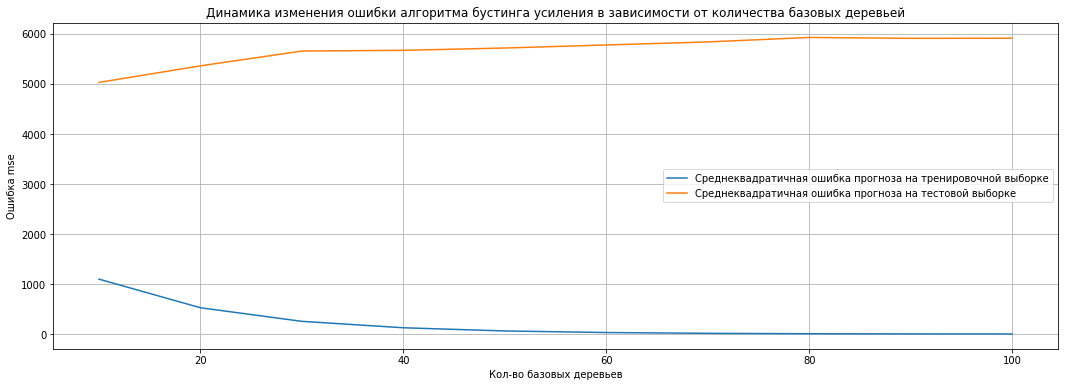

In [14]:
#Обучим несколько моделей с разными гипер-параметрами и исследуем их поведение:
#Параметр1: n_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] & max_depth = 3

# Число деревьев в ансамбле
n_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

train_mse = {}
test_mse = {}

for n in n_trees:
    coefs = [1] * n
    trees, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_mse_value, test_mse_value = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_mse[n] = train_mse_value
    test_mse[n] = test_mse_value 
    
plt.figure(figsize = (18,6))
plt.plot(list(train_mse.keys()), list(train_mse.values()), label = f'Среднеквадратичная ошибка прогноза на тренировочной выборке')
plt.plot(list(test_mse.keys()), list(test_mse.values()), label = f'Среднеквадратичная ошибка прогноза на тестовой выборке')
plt.legend()
plt.xlabel('Кол-во базовых деревьев')
plt.ylabel('Ошибка mse')
plt.title('Динамика изменения ошибки алгоритма бустинга усиления в зависимости от количества базовых деревьей')
plt.grid()

Смотрим на зависимость среднеквадратичной ошибки прогноза на валидации и тесте от гиперпараметра "кол-во деревьев, объединяемых в ансамбль". Видим, что по мере наращивания сложности модели ошибка на трейне перестает сильно изменяться после кол-ва
деревьев > 40, ошибка на валидации - наоборот продолжает расти после 40, что свидетельствует о переобучении модели. 
Зафиксируем этот гиперпараметр на уровне 40 и подберем глубину деревеьв.

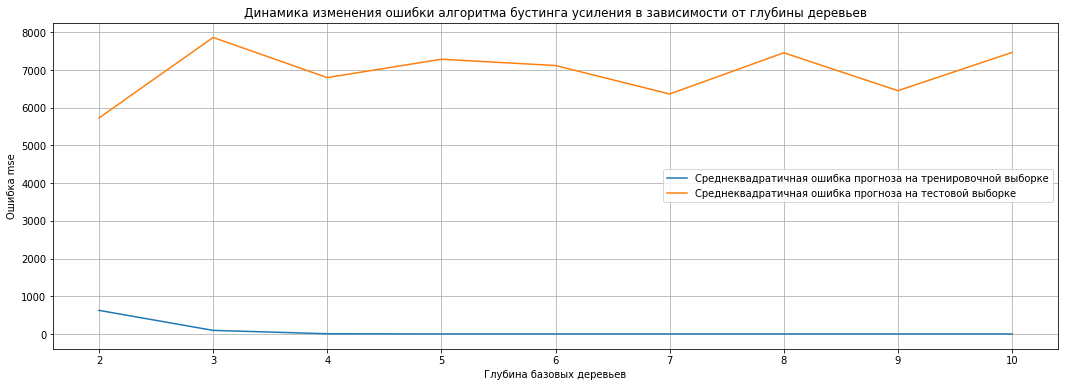

In [9]:
# Число деревьев в ансамбле
n_trees = 40

# Максимальная глубина деревьев
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Шаг
eta = 1

train_mse = {}
test_mse = {}

for depth in max_depth:
    coefs = [1] * n_trees
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_mse_value, test_mse_value = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_mse[depth] = train_mse_value
    test_mse[depth] = test_mse_value 
    
plt.figure(figsize = (18,6))
plt.plot(list(train_mse.keys()), list(train_mse.values()), label = f'Среднеквадратичная ошибка прогноза на тренировочной выборке')
plt.plot(list(test_mse.keys()), list(test_mse.values()), label = f'Среднеквадратичная ошибка прогноза на тестовой выборке')
plt.legend()
plt.xlabel('Глубина базовых деревьев')
plt.ylabel('Ошибка mse')
plt.title('Динамика изменения ошибки алгоритма бустинга усиления в зависимости от глубины деревьев')
plt.grid()

Смотрим на зависимость среднеквадратичной ошибки прогноза на валидации и тесте от гиперпараметра "глубина базовых деревьев". Видим, что на трейне при глубине деревьев > 3 ошибка почти не изменяется, она стабильна. Ошибка на валидации не выходит на
асимптоту, в качестве оптимальной глубины можно взять значение равное 4. В общем случае, чем больше глубина базовых деревьев,
тем больше вероятность переобучиться.

In [23]:
# Задача 2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки
# принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.
#Будем обучать каждый алгоритм по случайной подвыборке равной 0.5.

#Доля выборки, на которой мы будем обучаться
alpha = 0.5

def bagging(X_train, y_train):
    lenght = round(X_train.shape[0]*alpha)
    indexes = np.random.randint(X_train.shape[0], size = (1, lenght))
    X_train_bagging = X_train[indexes]
    y_train_bagging = y_train[indexes]
    return X_train_bagging, y_train_bagging

In [61]:
#Реализуем функцию обучения стохастического градиентного бустинга.
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
     
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            X_train_bagging, y_train_bagging = bagging(X_train, y_train)
            target = gb_predict(X_train_bagging[0], trees, coefs, eta)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_bagging[0], bias(y_train_bagging[0], target))
            
            train_errors.append(mean_squared_error(y_train_bagging[0], gb_predict(X_train_bagging[0], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Посмотрим, как изменяется среднеквадратичная ошибка прогноза на каждой итерации. Уменьшим шаг, так как обучаться мы будем каждый раз на 1/2 случайной подвыборке тестовой выборки.

In [68]:
# Число деревьев в ансамбле
n_trees = 40

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 4

# Шаг
eta = 0.05

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [69]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

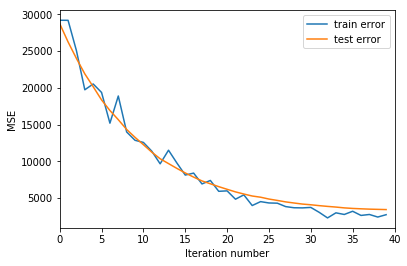

In [70]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что ошибка на валидации - не гладкая кривая, ее форма соответствует алгоритму, который мы использовали - стохатический xgb.
За 40 итераций достигаем того уровня mse, который мы достигали в обычном алгоритме бустинга, существенно сократив кол-во вычислительных операций.